In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import root

%run simulation
%run control
%run plotting

#from simulation import *
#from control import *
#from plotting import *

plt.style.use("dark_background")

In [15]:
# Set up initial conditions and parameters
t0 = 0
tf = 5
x0 = np.array([.5, -.5])
v0 = np.array([.5, 2])
masses = np.array([1,.09,0])

init = np.array([-.09, 0, 0, # Position 1
                 1, 0, 0, # Position 2
                 x0[0], x0[1], 0, # Position 3
                 0, -.09, 0, # Velocity/Momentum 1
                 0, 1, 0, # Velocity/Momentum 2
                 v0[0], v0[1], 0]) # Velocity 3 

# Solve the system
f = lambda t, y: gravity_acceleration_general(y, m=masses)
sol = solve_ivp(f, (t0, tf), init, t_eval= np.linspace(t0, tf, 1000), dense_output=True)

t_guess = 2, Position: [0.22631237 2.85722818]


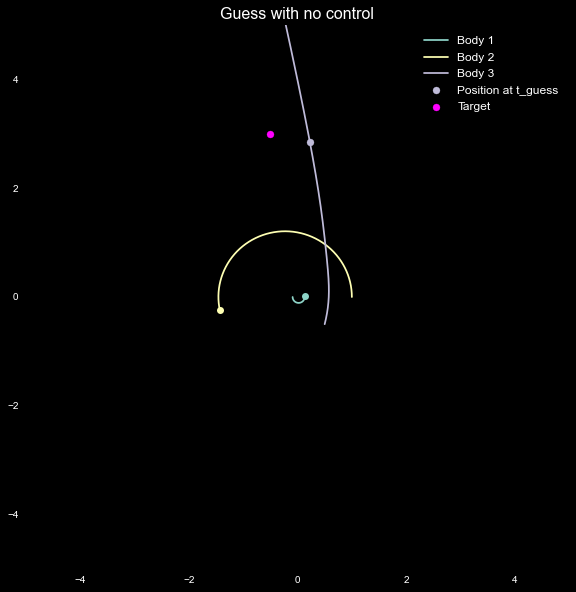

In [26]:
t_guess = 2
m0 = np.array([10])
target = np.array([-.5, 3]) #np.array([0, 1.7])

#Plot the initial system
pos_guess = sol.sol(t_guess)[6:8]
print(f"t_guess = {t_guess}, Position: {pos_guess}")

ax = plt.gca()
plt.scatter(*pos_guess, color="C2", marker='o', label="Position at t_guess", zorder=5)
plt.scatter(*target, color="magenta", marker='o', label="Target", zorder=6)
plot_nbody(sol.y, "Guess with no control", ax=ax)

plt.show()

In [27]:
sol2, u = solve_optimal_euclidean(sol, masses[:-1], x0, v0, m0, target, delta=1000, tf_guess=t_guess, p12_guess_strat="bolza",
                                  verbose=2, max_nodes=20_000)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.91e+02       3.85e+01          100            198      
       2          5.61e-04       1.20e-06          298             0       
Solved in 2 iterations, number of nodes 298. 
Maximum relative residual: 5.61e-04 
Maximum boundary residual: 1.20e-06


t_f = 2.2168959993891977
m_f = 4.307027654546444
x(t_f) =  [-0.47841337  3.01332287]


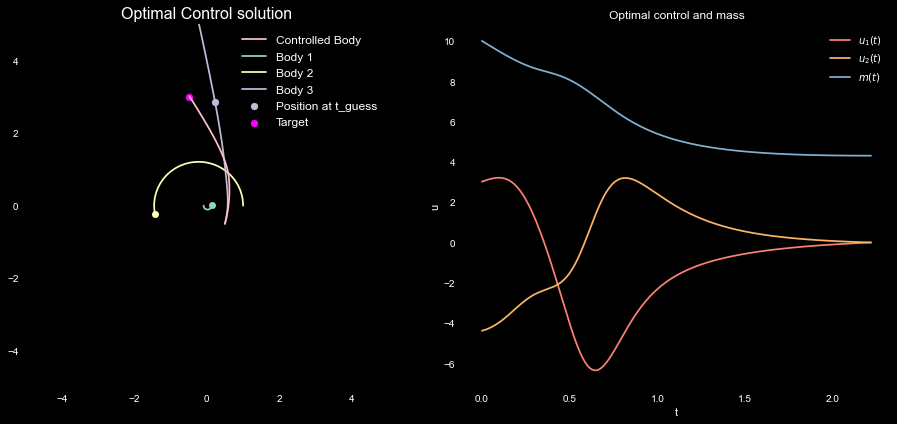

In [28]:
print("t_f =", sol2.p[0])
print("m_f =", sol2.y[4,-1])
print("x(t_f) = ", sol2.y[:2, -1])

fig, axs = plt.subplots(1,2, figsize=(13, 6))
ax1, ax2 = axs

ax1.plot(sol2.y[0], sol2.y[1], color = 'pink', zorder=10, label="Controlled Body")
ax1.scatter(*pos_guess, color="C2", marker='o', label="Position at t_guess", zorder=5)
ax1.scatter(*target, color="magenta", marker='o', label="Target", zorder=6)
plot_nbody(sol.y, "Optimal Control solution", ax=ax1)

#Plot optimal control over time
u1, u2 = u
t  = sol2.p[0]*sol2.x
ax2.plot(t, u1, c='C3', label="$u_1(t)$")
ax2.plot(t, u2, c='C5', label="$u_2(t)$")
ax2.plot(t, sol2.y[4], c='C4', label="$m(t)$")
ax2.set_xlabel("t")
ax2.set_ylabel("u")
ax2.legend()
ax2.grid() #remove grid
ax2.set_title("Optimal control and mass")

plt.tight_layout()
plt.show()